In this notebook, we will build an abstractive based text summarizer using deep learning from the scratch in python using keras.

Our objective here is to generate a summary for the Amazon Fine Food reviews using the abstraction-based approach we learned about above.



**Custom Attention Layer**

Keras does not officially support attention layer. So, we can either implement our own attention layer or use a third-party implementation.

In [7]:
from google.colab import drive
drive.mount('/content/drive')
datasets_path = '/content/drive/MyDrive/ml_datasets/amazon_reviews_summaries.csv'
dataset_name = 'amazon_reviews_summaries.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install keras-self-attention
from keras_self_attention import SeqSelfAttention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=40d9cde83dec3c5b7e6745bcaaa2dbe663aada5a8759eb64aa0a7abb547c3aa4
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


In [59]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
data = pd.read_csv(datasets_path, nrows=10000)
data.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...


In [10]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9513 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      9513 non-null   int64 
 1   ProductId               9513 non-null   object
 2   UserId                  9513 non-null   object
 3   ProfileName             9513 non-null   object
 4   HelpfulnessNumerator    9513 non-null   int64 
 5   HelpfulnessDenominator  9513 non-null   int64 
 6   Score                   9513 non-null   int64 
 7   Time                    9513 non-null   int64 
 8   Summary                 9513 non-null   object
 9   Text                    9513 non-null   object
dtypes: int64(5), object(5)
memory usage: 817.5+ KB


**TEXT PREPROCESSING:** We will perform the below **preprocessing** tasks for our data:

1.Convert everything to lowercase

2.Remove HTML tags

3.Contraction mapping

4.Remove (‘s)

5.Remove any text inside the parenthesis ( )

6.Eliminate punctuations and special characters

7.Remove stopwords

8.Remove short words

Let’s define the function:

In [12]:
## drop all the unwanted symbols, characters, etc. from the text that do not affect the objective of our problem.
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [16]:
stop_words = set(stopwords.words('english'))

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()

In [17]:
#call the function
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

In [19]:
cleaned_text[0:2]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo']

In [20]:
#call the function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [21]:
cleaned_summary[:2]

['good quality dog food', 'not as advertised']

In [22]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [23]:
# Drop empty rows
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

**Understanding the distribution of the sequences**

analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text. This will help us fix the maximum length of the sequence:

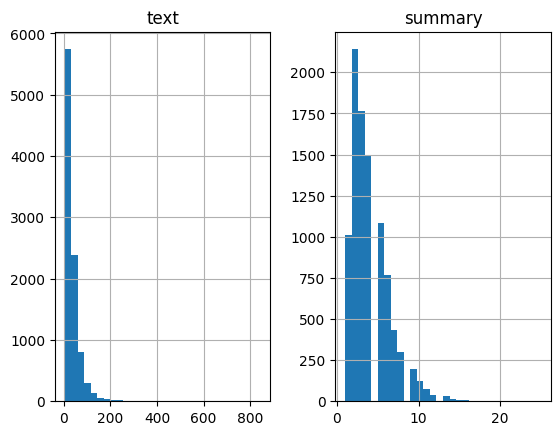

In [24]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [26]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9465544450289322


In [27]:
# We observe that 94% of the summaries have length below 8. So, we can fix maximum length of summary to 8.
# Let us fix the maximum length of review to 30

max_text_len=30
max_summary_len=8

In [28]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df = pd.DataFrame({'text':short_text,'summary':short_summary})

df.head(1)

,text,summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,good quality dog food


In [29]:
# Remember to add the START and END special tokens at the beginning and end of the summary. Here, I have chosen sostok and eostok as START and END tokens
# Note: Be sure that the chosen special tokens never appear in the summary

df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df['summary'].head(1)

,summary
0,sostok good quality dog food eostok


In [32]:
x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(df['text']),
    np.array(df['summary']),
    test_size=0.1,
    random_state=0,
    shuffle=True
    )

In [33]:
# Preparing the Tokenizer
# A tokenizer builds the vocabulary and converts a word sequence to an integer sequence.

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [45]:
list(x_tokenizer.word_counts.items())[0:10]

[('know', 137),
 ('cannot', 236),
 ('make', 305),
 ('tea', 391),
 ('good', 1175),
 ('granted', 1),
 ('south', 4),
 ('never', 161),
 ('enjoyed', 52),
 ('sweet', 237)]

In [40]:
# defining the threshold to be 4 which means word whose count is below 4 is considered as a rare word
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print('Total count of words:', tot_cnt)
print('Total count of rare words:', cnt)
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

Total count of words: 8175
Total count of rare words: 5591
% of rare words in vocabulary: 68.39143730886849
Total Coverage of rare words: 9.150849382372709


tot_cnt gives the size of vocabulary (which means every unique words in the text)

cnt gives me the no. of rare words whose count falls below threshold

tot_cnt - cnt gives me the top most common words

Let us define the tokenizer with top most common words for reviews.

In [46]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print('Size of vocabulary: ', x_voc)

Size of vocabulary:  2585


In [47]:
## Summary Tokenizer
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

thresh=6
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

# Let us check whether word count of start token is equal to length of the training data
y_tokenizer.word_counts['sostok'], len(y_tr)

% of rare words in vocabulary: 84.49258836944128
Total Coverage of rare words: 14.563302087943034


(4772, 4772)

In [48]:
## Deleting the rows that contain only START and END tokens
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

## **Model building**

We are finally at the model building part. But before we do that, we need
 to familiarize ourselves with a few terms which are required prior to building the model.

**Return Sequences** = True: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

**Return State** = True: When return state = True, LSTM produces the hidden state and cell state of the last timestep only

**Initial State**: This is used to initialize the internal states of the LSTM for the first timestep

**Stacked LSTM**: Stacked LSTM has multiple layers of LSTM stacked on top of each other. This leads to a better representation of the sequence. I encourage you to experiment with the multiple layers of the LSTM stacked on top of each other (it’s a great way to learn this)

Here, we are building a 3 stacked LSTM for the encoder:

In [49]:
from keras import backend as K
K.clear_session()

latent_dim = 300
embedding_dim=100
max_text_len=30  # Based on histogram of text from dataset
max_summary_len=8  # Based on histogram of summary from dataset

In [61]:
# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

#encoder lstm 1 (Similarly encoder lstm 2 and 3 can be added)
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output, state_h, state_c = encoder_lstm1(enc_emb)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# # Attention layer
# attn_layer = Attention(use_scale=False, score_mode="dot", dropout=0.0, name='attention_layer')
# attn_out, attn_states = attn_layer([encoder_output, decoder_outputs])
# # Concat attention input and decoder LSTM output
# decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 30)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_6             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 30, 100)        │        258,500 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_6 (Embedding)   │ (None, None, 100)      │         40,900 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ [(None, 30, 300),      │        481,200 │ embedding_5[0][0]      │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ [(None, None, 300),    │        481,200 │ embedding_6[0][0],     │
│                           │ (None, 300), (None,    │                │ lstm_4[0][1],          │
│                           │ 300)]                  │                │ lstm_4[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 409)      │        123,109 │ lstm_5[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,384,909 (5.28 MB)

 Trainable params: 1,384,909 (5.28 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
# using sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# model will stop training once the validation loss increases:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

history= model.fit(
    [x_tr, y_tr[:,:-1]],
    y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:],
    epochs=5,
    callbacks=[es],
    batch_size=128,
    validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:])
    )

Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 23s 534ms/step - loss: 2.5534 - val_loss: 2.2053
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 532ms/step - loss: 2.1987 - val_loss: 2.1453
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 481ms/step - loss: 2.1504 - val_loss: 2.1157
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 23s 562ms/step - loss: 2.1488 - val_loss: 2.1165
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 508ms/step - loss: 2.1135 - val_loss: 2.0957


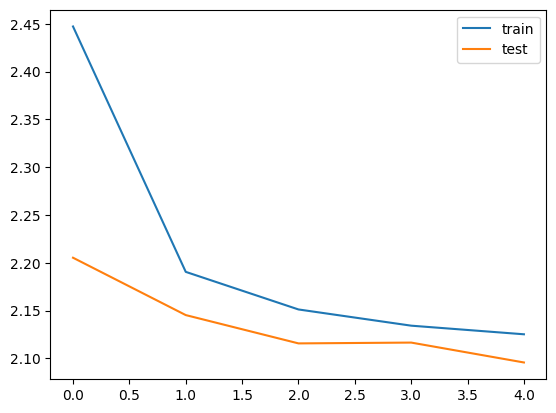

In [66]:
## Diagnostics plot
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [75]:
reverse_target_word_index  =  y_tokenizer.index_word
reverse_source_word_index  =  x_tokenizer.index_word
target_word_index  =  y_tokenizer.word_index

**Inference**

In [67]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_output, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

## attention inference
# attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
# decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs3 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [68]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [69]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [76]:
for i in range(0, 5):
  print("Review:", seq2text(x_tr[i]))
  print("Original summary:", seq2summary(y_tr[i]))
  print("Predicted summary:", decode_sequence(x_tr[i].reshape(1,max_text_len)))
  print("\n")

Review: know cannot make tea good south know never enjoyed tea sweet without sweet tastes crisp 
Original summary: this is the best 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Predicted summary: 


Review: disappointing folks like say tofu flavor type watery product buy soon got shopping awful disappointing benefits packaging shelf life 
Original summary: soft for tofu 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Predicted summary: 


Review: cup gf bisquick cup soy almond milk cup favorite fruit bake quick delicious gluten free bisquick quite fluffy crumbly original definitely worth gf 
Original summary: great for 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted summary: 


Review: love product best natural sweetener ever tried tried many use also pancake syrup substitute honey peanut butter honey sandwich last long time good value 
Original summary: the best 
1/1 ━━━━━━━━━━━━━━━━━

**How can we Improve the Model’s Performance Even Further?**

    Your learning doesn’t stop here! There’s a lot more you can do to play around and experiment with the model:

    I recommend you to increase the training dataset size and build the model. The generalization capability of a deep learning model enhances with an increase in the training dataset size

    Try implementing Bi-Directional LSTM which is capable of capturing the context from both the directions and results in a better context vector

    Use the beam search strategy for decoding the test sequence instead of using the greedy approach (argmax)

    Evaluate the performance of your model based on the BLEU score

    Implement pointer-generator networks and coverage mechanisms